In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from tqdm.notebook import trange


# create image

In [2]:
NAME = 'Princess'
# NAME = 'Hasan'
FONT_SIZE = 60
FONT = 'DejaVuSans.ttf'
BLADE_MIN_SCALE = .07
BLADE_MAX_SCALE = .11
GEO_SCALE = 100
NUM_BLADES = 1_000_000


text_size = (246, 71)


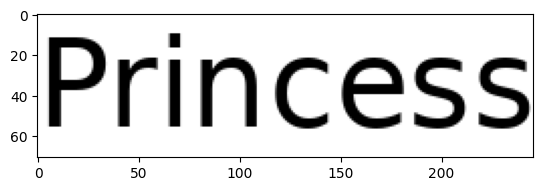

In [3]:
font = ImageFont.truetype(FONT, FONT_SIZE)
text_size = (int(font.getlength(NAME)), sum(font.getmetrics()))
print(f'{text_size = }')
image = Image.new(mode='RGB', size=text_size, color='white')
draw = ImageDraw.Draw(image)
draw.text((0, 0), NAME, (0, 0, 0), font=font)
plt.imshow(image)
image_np = np.array(image)


# load 3d models

In [4]:
def load_obj(obj_path: Path) -> tuple[np.ndarray, list[str], list[str]]:
    data = obj_path.read_text().strip().split('\n')
    vertices = np.array(
        [
            [float(j) for j in i[2:].split(' ')]
            for i
            in data
            if i.startswith('v ')
        ]
    )
    faces = [i for i in data if i.startswith('f ')]
    texture_vertices = [i for i in data if i.startswith('vt ')]
    return vertices, faces, texture_vertices


def save_obj(
        obj_path: Path,
        vertices: np.ndarray,
        texture_vertices: list[str],
        faces: list[str],
) -> None:
    obj_text = ''
    for v in vertices:
        v_text = ' '.join([str(i) for i in v])
        obj_text += f'v {v_text}\n'
    obj_text += '\n' + '\n'.join(texture_vertices)
    obj_text += '\n' * 2 + '\n'.join(faces)
    obj_path.write_text(obj_text)


def random_green() -> np.ndarray:
    color = np.array(
        [
            np.random.uniform(0., .1),
            np.random.uniform(.4, .7),
            np.random.uniform(.1, .3),
        ]
    )
    return color


def random_white() -> np.ndarray:
    color = np.array([np.random.uniform(.7, .9)] * 3)
    return color


def apply_rodrigues_rotation(
        vertices: np.ndarray,
        rotation_vector: np.ndarray,
        rotation_radian: float,
) -> np.ndarray:
    rotation_vector = rotation_vector / np.linalg.norm(rotation_vector)
    cos_theta = np.cos(rotation_radian)
    sin_theta = np.sin(rotation_radian)

    term1 = vertices * cos_theta
    term2 = np.cross(rotation_vector, vertices) * sin_theta
    term3 = (
        rotation_vector.reshape(3, 1)
        * np.dot(vertices, rotation_vector)
        * (1 - cos_theta)
    )

    return term1 + term2 + term3.T


In [5]:
rotation_vector = np.array([0, 0, 1]).astype(np.float32)
vector = np.array([[1, 0, 0]])
apply_rodrigues_rotation(vector, rotation_vector, np.pi / 2)


array([[6.123234e-17, 1.000000e+00, 0.000000e+00]])

In [6]:
blade_base_path = Path('blades')
blade_obj_files = sorted(blade_base_path.rglob('*.obj'))
blade_obj_path = blade_obj_files[0]


In [7]:
vertices, faces, texture_vertices = load_obj(blade_obj_path)
save_obj(Path('zz.obj'), vertices, texture_vertices, faces)


In [8]:
%%bash
rm results/*.obj


In [9]:
rotation_vector = np.array([0, 1, 0]).astype(np.float32)
for i in trange(NUM_BLADES // 10):
    # select and load random blade
    vertices, faces, texture_vertices = load_obj(np.random.choice(blade_obj_files))
    # random rotation
    theta = np.random.uniform(0, 2 * np.pi)
    vertices = apply_rodrigues_rotation(vertices, rotation_vector, theta)
    # random scale
    vertices *= np.random.uniform(BLADE_MIN_SCALE, BLADE_MAX_SCALE)
    # random position
    xd = np.random.uniform(0, text_size[0])
    zd =  np.random.uniform(0, text_size[1])
    vertices += np.array([xd, 0, zd]) / GEO_SCALE
    # random color
    if image.getpixel((xd, zd))[0] > 127:
        save_obj(Path(f'results/grass{i:09d}-G.obj'), vertices, texture_vertices, faces)
    else:
        save_obj(Path(f'results/grass{i:09d}-W.obj'), vertices, texture_vertices, faces)


  0%|          | 0/100000 [00:00<?, ?it/s]